In [1]:
import os, sys

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

from sklearn.utils.extmath import row_norms
from sklearn.metrics.pairwise import _euclidean_distances


project_dir = os.path.abspath("..")
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

import yace.helpers.evaluation as yace_eval

from yace.run_worker import JobInfo


In [2]:
def get_raw_results(file_paths):
    data_frames = []
    for index, job_info_path in enumerate(file_paths):
        job_info = JobInfo.load_json(job_info_path)
        experiment_type = job_info.command_params["experiment-type"]
        working_dir = job_info_path.parent
        duration_secs = int((job_info.completed_at - job_info.started_at).total_seconds())
        
        distortions_paths = list(working_dir.glob("distortions*.feather"))
        if len(distortions_paths) == 0:
            continue

        df_perf_data = pd.concat([
            pd.read_feather(file_path)
            for file_path in distortions_paths
        ])
        df_perf_data["experiment_id"] = working_dir.name
        df_perf_data["experiment_name"] = working_dir.parent.name
        df_perf_data["experiment_type"] = experiment_type
        df_perf_data["running_time_secs"] = duration_secs
        
        df_perf_data["algorithm"] = job_info.experiment_params["algorithm_name"]
        df_perf_data["job_info_path"] = job_info_path
        
        for param, val in job_info.experiment_params.items():
            df_perf_data[f"{param}"] = val
        
        data_frames.append(df_perf_data)
    df_data = pd.concat(data_frames)
    return df_data

def add_combined_mean_std(df: pd.DataFrame, attr: str):
    def combiner(row) -> str:
        mean = row[f"{attr}_mean"]
        std =  row[f"{attr}_std"]
        return f"{mean:0.4f} ({std:0.5f})"
    df[f"{attr}_mean_std"] = df.apply(lambda x: combiner(x), axis=1)


In [3]:
job_info_paths = list(Path("../data/experiments-odin/adv/ss_us_01").glob("**/job-info.json"))
print(f"Number of job files: {len(job_info_paths)}")

Number of job files: 200


In [4]:
df_raw_results = get_raw_results(job_info_paths)
print(f"Number of results: {df_raw_results.shape[0]}")

Number of results: 30000


In [5]:
grouping_cols = ["experiment_name", "epsilon", "k",  "algorithm_name", "solution_type"]
aggregation_spec = dict(
    distortion_mean=("distortion", np.mean),
    distortion_std=("distortion", np.std),
    n_solutions=("distortion", "count")
)
df_grouped = df_raw_results.groupby(grouping_cols).agg(**aggregation_spec).reset_index()
df_grouped

,experiment_name,epsilon,k,algorithm_name,solution_type,distortion_mean,distortion_std,n_solutions
0,ss_us_01,0.01,10,sensitivity-sampling,adv0_33,1.006471,0.005275,250
1,ss_us_01,0.01,10,sensitivity-sampling,adv0_50,1.008646,0.006933,250
2,ss_us_01,0.01,10,sensitivity-sampling,adv0_67,1.010445,0.008108,250
3,ss_us_01,0.01,10,uniform-sampling,adv0_33,1.004817,0.003963,250
4,ss_us_01,0.01,10,uniform-sampling,adv0_50,1.006053,0.004823,250
...,...,...,...,...,...,...,...,...
115,ss_us_01,0.20,100,sensitivity-sampling,adv0_50,1.007665,0.006521,250
116,ss_us_01,0.20,100,sensitivity-sampling,adv0_67,1.007773,0.006326,250
117,ss_us_01,0.20,100,uniform-sampling,adv0_33,1.009553,0.006298,250
118,ss_us_01,0.20,100,uniform-sampling,adv0_50,1.009444,0.006611,250


In [6]:
pd.pivot(
    data=df_grouped,
    index=["experiment_name", "epsilon", "k", "solution_type"],
    columns=["algorithm_name"], 
    values="distortion_mean"
)

algorithm_name                             sensitivity-sampling  \
experiment_name epsilon k   solution_type                         
ss_us_01        0.01    10  adv0_33                    1.006471   
                            adv0_50                    1.008646   
                            adv0_67                    1.010445   
                        20  adv0_33                    1.003728   
                            adv0_50                    1.005170   
                            adv0_67                    1.007518   
                        50  adv0_33                    1.001093   
                            adv0_50                    1.001828   
                            adv0_67                    1.002442   
                        70  adv0_33                    1.001034   
                            adv0_50                    1.001339   
                            adv0_67                    1.002098   
                        100 adv0_33                    1.000598   
                            adv0_50                    1.000871   
                            adv0_67                    1.001494   
                0.05    10  adv0_33                    1.033036   
                            adv0_50                    1.039779   
                            adv0_67                    1.044232   
                        20  adv0_33                    1.010197   
                            adv0_50                    1.012142   
                            adv0_67                    1.015280   
                        50  adv0_33                    1.005009   
                            adv0_50                    1.006458   
                            adv0_67                    1.007421   
                        70  adv0_33                    1.002985   
                            adv0_50                    1.004110   
                            adv0_67                    1.004858   
                        100 adv0_33                    1.004137   
                            adv0_50                    1.004279   
                            adv0_67                    1.004828   
                0.10    10  adv0_33                    1.045027   
                            adv0_50                    1.048110   
                            adv0_67                    1.054570   
                        20  adv0_33                    1.017554   
                            adv0_50                    1.023188   
                            adv0_67                    1.029787   
                        50  adv0_33                    1.008216   
                            adv0_50                    1.009289   
                            adv0_67                    1.009649   
                        70  adv0_33                    1.007217   
                            adv0_50                    1.007939   
                            adv0_67                    1.008514   
                        100 adv0_33                    1.003270   
                            adv0_50                    1.003837   
                            adv0_67                    1.004541   
                0.20    10  adv0_33                    1.093509   
                            adv0_50                    1.104772   
                            adv0_67                    1.103539   
                        20  adv0_33                    1.040430   
                            adv0_50                    1.044447   
                            adv0_67                    1.046634   
                        50  adv0_33                    1.019252   
                            adv0_50                    1.019178   
                            adv0_67                    1.019226   
                        70  adv0_33                    1.012478   
                            adv0_50                    1.011985   
                            adv0_67                    1.012064   
                        100 adv0_33            

In [7]:
colors = sns.color_palette("tab10")
colors = sns.color_palette("bright")
algorithms = np.sort(df_raw_results.algorithm_name.unique())[::-1]
algorithm_colors = {algo: colors[i] for i, algo in enumerate(algorithms)}
df_raw_results["k_formatted"] = "$k$=" + df_raw_results["k"].astype(str)
df_grouped["k_formatted"] = "$k$=" + df_grouped["k"].astype(str)

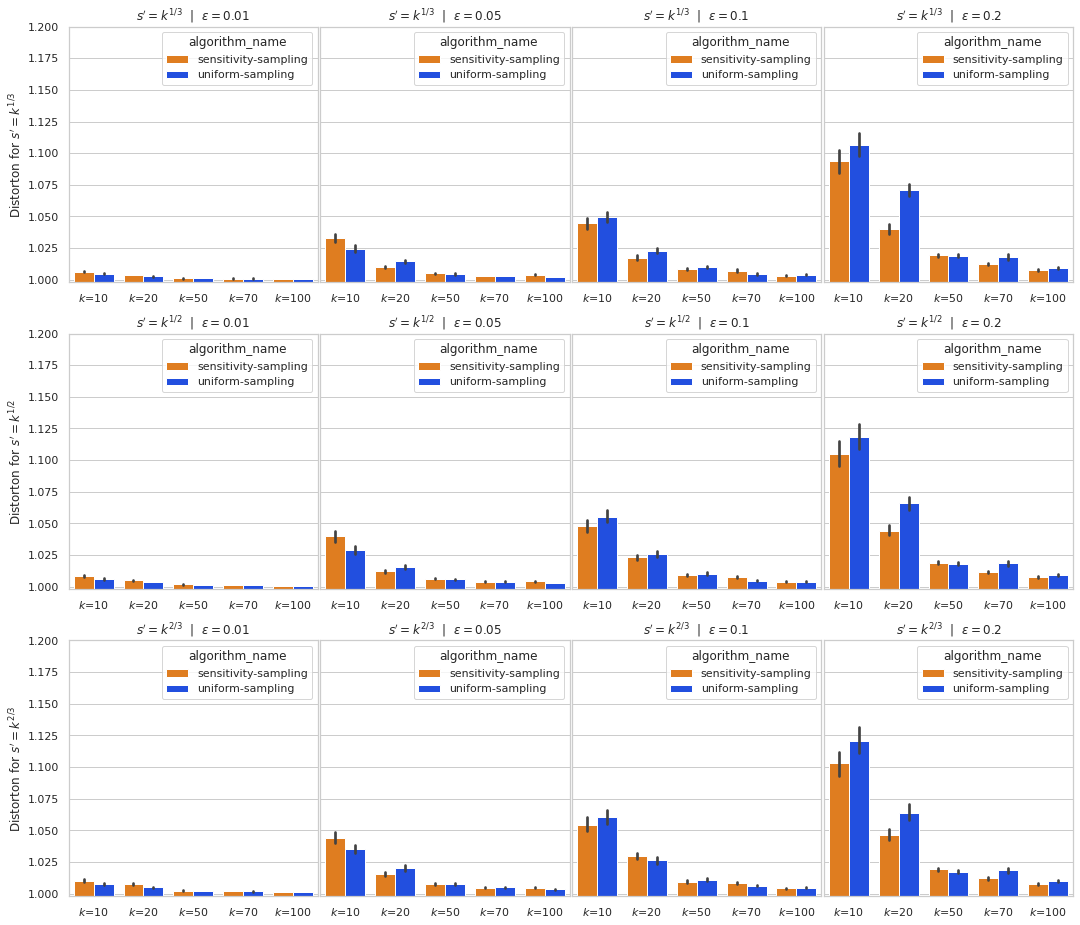

In [8]:
solution_types = np.sort(df_raw_results["solution_type"].unique())
epsilons = np.sort(df_raw_results["epsilon"].unique())
n_rows = len(solution_types)
n_cols = len(epsilons)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharey=True, figsize=(18, 16))

for i, solution_type in enumerate(solution_types):
    for j, epsilon in enumerate(epsilons):
        ax = axes[i,j] # axes[i,j]
        f1 = df_raw_results["solution_type"] == solution_type
        f2 = df_raw_results["epsilon"] == epsilon
        df_filtered = df_raw_results[f1&f2].copy()
        df_filtered.sort_values(by=["k", "algorithm_name"], inplace=True)
        sns.barplot(data=df_filtered, x="k_formatted", y="distortion", hue="algorithm_name", ax=ax, palette=algorithm_colors)
        ax.set_ylim(bottom=0.998, top=1.2)
        ratio = {"adv0_50": "1/2", "adv0_33": "1/3", "adv0_67": "2/3"}[solution_type]
        s_prime = f"$s'=k^{{{ratio}}}$"
        ax.set_title(f"{s_prime}  |  $\\epsilon={epsilon}$")
        ax.set_ylabel(f"Distorton for {s_prime}")
        ax.set_xlabel("")
        if j > 0:
            ax.set_ylabel("")            
        if i == 0:
            ax.set_xlabel("")
fig.subplots_adjust(wspace=0.01)
# fig.savefig("distortions-instance-2-v3.pdf", )

## Weight distribution

In [9]:
def get_weights(df_data, epsilon: float=0.2, k: int=10):
    results = []
    for algo in ['uniform-sampling', 'sensitivity-sampling']:
        f1 = df_data["solution_type"] == "adv0_50"
        f2 = df_data["epsilon"] == epsilon
        f3 = df_data["algorithm"] == algo
        f4 = df_data["k"] == k
        
        df_filtered = df_data[f1&f2&f3&f4].copy()
        
        job_info_path = df_filtered.sample(1)["job_info_path"].iloc[0]
        weights = np.load(job_info_path.parent / "coreset-weights.npz")["matrix"]
        results.append(weights)
    return results[0], results[1]

In [10]:
us_coreset_weights, ss_coreset_weights = get_weights(df_data=df_raw_results, epsilon=0.01, k=10)

In [11]:
ss_coreset_weights.mean()

31.622499999999995

In [12]:
us_coreset_weights

array([31.6225, 31.6225, 31.6225, ..., 31.6225, 31.6225, 31.6225])

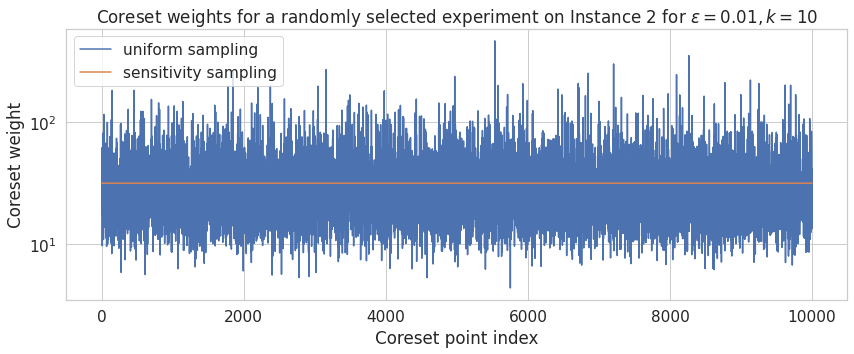

In [13]:
with sns.plotting_context("notebook", font_scale=1.4):
    a = np.arange(ss_coreset_weights.shape[0])
    fig, ax = plt.subplots(figsize=(14, 5))
    sns.lineplot(x=a, y=ss_coreset_weights, label="uniform sampling", ax=ax)
    sns.lineplot(x=a, y=us_coreset_weights, label="sensitivity sampling", ax=ax)
    ax.set_ylabel("Coreset weight")
    ax.set_xlabel("Coreset point index")
    ax.set_yscale("log")
    ax.set_title("Coreset weights for a randomly selected experiment on Instance 2 for $\\epsilon=0.01, k=10$")